In [1]:
import time

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import style

from more_itertools import chunked

from google.cloud import storage

In [2]:
# Configuration constants
VALIDATION_RATIO = 0.1

In [ ]:
client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

blobs = bucket.list_blobs()
for blob in blobs:
    print(blob.name)

In [ ]:
blob_name = "celeba/processed/celebalign_processed1.npy"
blob = bucket.get_blob(blob_name)
data_file = "/home/jupyter/data/celeb-align-1/processed/celebalign_processed1.npy"
blob.download_to_filename(data_file)

In [3]:
data_file = "/home/jupyter/data/celeb-align-1/tensors/celebalign_processed_100_000_horizontal.torch"
data = torch.load(data_file)

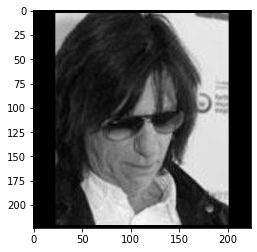

In [4]:
plt.imshow(data["x"][2], cmap="gray");

In [5]:
print(data["x"][0].shape)
IMAGE_SIZE = data["x"][0].shape[0]
NUM_CLASSES = data["num_classes"]

torch.Size([224, 224])


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
# x = torch.Tensor(list(data[0])).view(-1, IMAGE_SIZE, IMAGE_SIZE)
# x /= 255.0
# x = data["x"]

In [7]:
unique = set(data["y"])
class_mapping = {elem: idx for idx, elem in enumerate(unique)}

In [ ]:
# y = torch.Tensor([class_mapping[elem] for elem in data[1]]).to(torch.int64)
# y = data["y"]

In [8]:
val_size = int(len(data["x"]) * VALIDATION_RATIO)
print(val_size)

10001


In [9]:
train_x = data["x"][:-val_size]
train_y = data["y"][:-val_size]

In [10]:
def fwd_pass(x, y,
             loss_func,
             optim,
             train=False):
        
    if train:
        net.zero_grad()
    out = net(x)
    acc = np.mean([int(torch.argmax(y_pred) == y_real) for y_pred, y_real in zip(out, y)])
    loss = loss_func(out, y)

    if train:
        loss.backward()
        optim.step()

    return acc, loss

In [11]:
test_x = data["x"][-val_size:]
test_y = data["y"][-val_size:]

In [12]:
def test(size, loss_func, optim):
    tx, ty = test_x[:size].to(device), test_y[:size].to(device)
    val_acc, val_loss = fwd_pass(tx.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to(device), ty.to(device), loss_func, optim)
    return val_acc, val_loss

In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import models.vgg11

import importlib
importlib.reload(models.vgg11)

<module 'models.vgg11' from '/home/jupyter/face-recognizer-9000/models/vgg11.py'>

In [21]:
# Only run if need to delete memory
import gc
del net
gc.collect()
torch.cuda.empty_cache()

In [14]:
net = models.vgg11.FleetwoodNet11V1(NUM_CLASSES).to(device)
print(net)

FleetwoodNet11V1(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [ ]:
MODEL_NAME = f"{type(net).__name__}-{int(time.time())}"
print(f"Model name: {MODEL_NAME}")
saves_path = "/home/jupyter/checkpoints"
CHECKPOINT_EVERY_STEP = 2_000

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.NLLLoss()

def train(net):
    BATCH_SIZE = 10
    EPOCHS = 5

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            it = tqdm(range(0, len(train_x), BATCH_SIZE))
            for i in it:
                batch_x = train_x[i:i+BATCH_SIZE].view(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                acc, loss = fwd_pass(
                    batch_x, batch_y,
                    loss_function,
                    optimizer,
                    train=True,
                )
                
                it.set_postfix({"acc": acc})

                if i != 0 and i % CHECKPOINT_EVERY_STEP == 0:
                    val_acc, val_loss = test(size=100, loss_func=loss_function, optim=optimizer)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

                    idx = i // CHECKPOINT_EVERY_STEP
                    torch.save({
                                    "model_state_dict": net.state_dict(),
                                    "optimizer_state_dict": optimizer.state_dict(),
                                    "val_acc": val_acc,
                                    "val_loss": val_loss,
                                },
                        os.path.join(saves_path, f"{MODEL_NAME}-{idx}.data"),
                    )
            print(f"Epoch: {epoch}. Loss: {loss}.")
train(net)

  0%|          | 0/9002 [00:00<?, ?it/s]

Model name: FleetwoodNet11V1-1604928337


  1%|          | 56/9002 [00:08<19:37,  7.60it/s, acc=0]   

In [ ]:
style.use("ggplot")



def create_acc_loss_graph(model_name):
    times = []
    accs = []
    losses = []
    
    val_accs = []
    val_losses = []
    
    with open("model.log", "r") as f:
        
        for line in f.readlines():
            name, time, acc, loss, val_acc, val_loss = line.split(",")
            
            times.append(float(time))
            accs.append(float(acc))
            losses.append(float(loss))
            
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
            
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    
    ax1.plot(times, accs, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(MODEL_NAME)

In [ ]:
# Not currently in use, I think
correct = 0

with torch.no_grad():
    for i, y_real in enumerate(tqdm(test_y)):
        real_class = torch.argmax(y_real)
        pred_class = torch.argmax(net(test_x[i].view(-1, 1, IMAGE_SIZE, IMAGE_SIZE))[0])
        
        correct += int(real_class == pred_class)
        
print(f"Accuracy: {round(correct / len(test_x), 3)}")

In [ ]:
for im in test_x:
    pred = int(torch.argmax(net(im.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE))))
    convert = {0: "Cat", 1: "Dog"}
    print(f"Net predicted it is `{convert[pred]}`")
    
    plt.imshow(im.cpu(),cmap="gray")
    plt.pause(0.05)
    print("="*50)